In [ ]:
import tensorflow as tf

In [ ]:
#print tensorflow version
print(tf.__version__)

2.12.0


In [ ]:
# connect to google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#define the path and split your data into training and validation split
dataset=tf.keras.preprocessing.image_dataset_from_directory(
        "/content/gdrive/MyDrive/flower_photos")
ds_train = tf.keras.preprocessing.image_dataset_from_directory(
        "/content/gdrive/MyDrive/flower_photos",
        validation_split=0.2,
        subset="training",
        seed=123)
ds_validation = tf.keras.preprocessing.image_dataset_from_directory(
        "/content/gdrive/MyDrive/flower_photos",
        validation_split=0.2,
        subset="validation",
        seed=123)

Found 3670 files belonging to 5 classes.
Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
# define the batch size and print the image labels
import tensorflow_datasets as tfds

batch_size = 64

dataset_name = dataset
class_names = dataset.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [ ]:
val_batches = tf.data.experimental.cardinality(ds_validation)
test_dataset = ds_validation.take(val_batches // 5)
validation_dataset = ds_validation.skip(val_batches // 5)

In [ ]:
#reseize your images and standardize your data to make it for a nueral network
#Standardize your data
size = (512, 512)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_val= ds_validation.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = test_dataset.map(lambda image, label: (tf.image.resize(image, size), label))

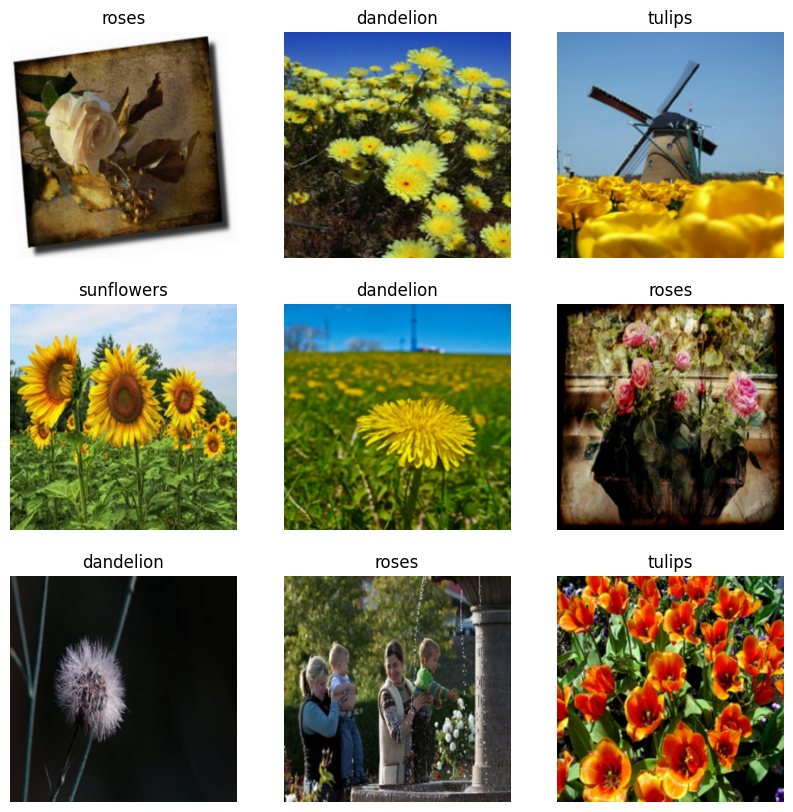

In [ ]:
# display the first 9 images
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in ds_train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
#do further preprocessing to increase the instances of images
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers


image = Sequential(
  [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(height_factor=(-0.2, -0.3), width_factor=(-0.2, -0.3), interpolation='bilinear'),
    layers.RandomContrast(factor=0.1),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    ],
    name="image",
)


<ipython-input-9-4fdc8b2b7fe4>:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.int(x)


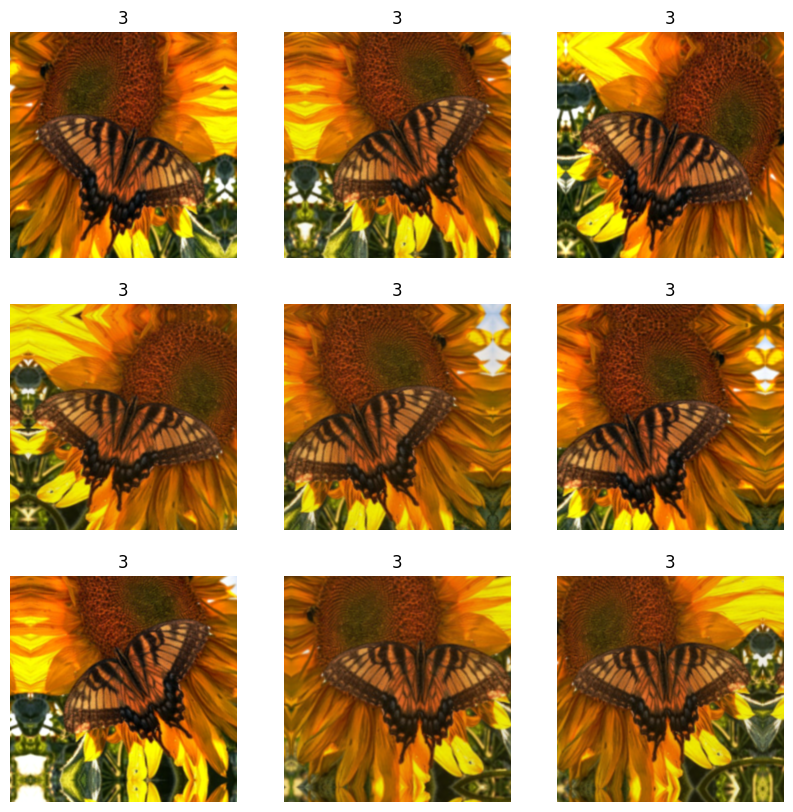

In [ ]:
import numpy as np

for images, labels in ds_train.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    def f(x):
      return np.int(x)
    f2 = np.vectorize(f)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = image(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(f2(labels[0]))
        plt.axis("off")

In [ ]:
NUM_CLASSES=len(class_names)

In [ ]:
!pip install tensorflow-addons
import tensorflow_addons as tfa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# One-hot / categorical encoding
def input_preprocess(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


ds_train = ds_train.map(
    input_preprocess, num_parallel_calls=tf.data.AUTOTUNE
)

ds_train = ds_train.prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(input_preprocess)
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)
ds_val = ds_val.map(input_preprocess)
ds_val = ds_val.prefetch(tf.data.AUTOTUNE)

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(512, 512, 3)),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(5, activation='softmax')
])

In [ ]:
# Compile the model

model.compile(
        optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.Precision(name='precision'), tfa.metrics.F1Score(name= 'f1_score', num_classes=5),
        ]
    )

In [ ]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 510, 510, 32)      896       
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 255, 255, 32)     0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 255, 255, 32)      0         
                                                                 
 conv2d_35 (Conv2D)          (None, 253, 253, 64)      18496     
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 126, 126, 64)     0         
 g2D)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 126, 126, 64)    

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
es = EarlyStopping(monitor = "val_accuracy", min_delta = 0.01, patience = 10,verbose = 1)

model_cp = ModelCheckpoint(filepath="/content/gdrive/MyDrive/Weights/myCNN_modelv1.H5 ", monitor = "val_accuracy",
                           save_best_only = True,
                           save_weights_only=False,
                           verbose = 1)

In [ ]:
# train the model
epochs = 3
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_val, callbacks=[model_cp, es], batch_size=64, verbose=1)

Epoch 1/3
92/92 [==============================] - ETA: 0s - loss: 1050.5508 - accuracy: 0.3001 - recall: 0.1291 - precision: 0.3034 - f1_score: 0.2907
Epoch 1: val_accuracy improved from -inf to 0.24932, saving model to /content/gdrive/MyDrive/Weights/myCNN_modelv1.H5 


92/92 [==============================] - 62s 608ms/step - loss: 1050.5508 - accuracy: 0.3001 - recall: 0.1291 - precision: 0.3034 - f1_score: 0.2907 - val_loss: 1.6042 - val_accuracy: 0.2493 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_f1_score: 0.1091
Epoch 2/3
92/92 [==============================] - ETA: 0s - loss: 1.4034 - accuracy: 0.4315 - recall: 0.1294 - precision: 0.5994 - f1_score: 0.4226
Epoch 2: val_accuracy improved from 0.24932 to 0.25204, saving model to /content/gdrive/MyDrive/Weights/myCNN_modelv1.H5 


92/92 [==============================] - 72s 622ms/step - loss: 1.4034 - accuracy: 0.4315 - recall: 0.1294 - precision: 0.5994 - f1_score: 0.4226 - val_loss: 1.6017 - val_accuracy: 0.2520 - val_recall: 0.0027 - val_precision: 0.6667 - val_f1_score: 0.1160
Epoch 3/3
92/92 [==============================] - ETA: 0s - loss: 1.2545 - accuracy: 0.5150 - recall: 0.2347 - precision: 0.6939 - f1_score: 0.5120
Epoch 3: val_accuracy improved from 0.25204 to 0.26567, saving model to /content/gdrive/MyDrive/Weights/myCNN_modelv1.H5 


92/92 [==============================] - 57s 609ms/step - loss: 1.2545 - accuracy: 0.5150 - recall: 0.2347 - precision: 0.6939 - f1_score: 0.5120 - val_loss: 1.6079 - val_accuracy: 0.2657 - val_recall: 0.0068 - val_precision: 0.2778 - val_f1_score: 0.1464


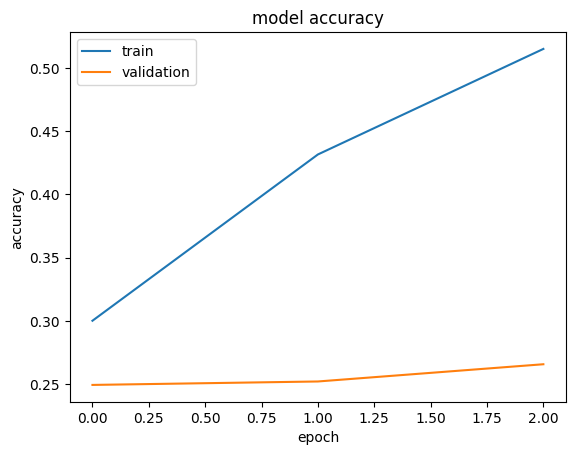

In [ ]:
# Visualize the training and validation curves
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(hist)

In [ ]:
test=ds_test
from tensorflow_addons.metrics import cohens_kappa
loss, accuracy, precision, recall, f1_score =  model.evaluate(test)
print('Test accuracy :', accuracy)
print('Precision :', precision)
print('recall :', recall)
print('f1_score :', f1_score)


4/4 [==============================] - 2s 244ms/step - loss: 1.5791 - accuracy: 0.2734 - recall: 0.0078 - precision: 1.0000 - f1_score: 0.1661
Test accuracy : 0.2734375
Precision : 0.0078125
recall : 1.0
f1_score : [0.2962963  0.38926175 0.09090909 0.         0.05405406]
